# Машинное обучение, ФКН ВШЭ

## Практическое задание (Бонус). Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 23:59MSK 24.12.2023

Жесткий дедлайн: 23:59MSK 24.12.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 6 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [75]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

c:\Users\rusta\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.932175246772296

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (1.5 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [44]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    data = {'Index': list(range(0, len(y))), 'y_true': y} 
    df = pd.DataFrame(data)

    for i in range(num_runs):
        bootstrap_indexes = np.random.randint(0, X.shape[0], X.shape[0])
        X_bootstrap = X[bootstrap_indexes]
        y_bootstrap = y[bootstrap_indexes]
        regressor.fit(X_bootstrap, y_bootstrap)
        out_of_bag_indexes = list(set(list(range(0, X.shape[0]))) - set(bootstrap_indexes))
        y_true = y[out_of_bag_indexes]
        predicts = regressor.predict(X[out_of_bag_indexes])
        temp_df = pd.DataFrame({'Index': out_of_bag_indexes, f'Column_{i+1}': predicts})
        df = df.merge(temp_df, left_on='Index', right_on='Index', how='left')
    df.drop('Index', axis=1, inplace=True)

    predictions = df.drop('y_true', axis=1)
    mean_predictions = predictions.mean(axis=1)
    bias = ((mean_predictions - df['y_true']) ** 2).mean()
    variance = predictions.var(axis=1).mean()
    error = ((predictions.sub(df['y_true'], axis=0) ** 2).mean()).mean()

    return bias, variance, error

    

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [57]:
lin_reg = LinearRegression()
dt_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor()

bias_var_error_lin_reg = compute_biase_variance(lin_reg, X, y)
bias_var_error_dt_reg = compute_biase_variance(dt_reg, X, y)
bias_var_error_rf_reg = compute_biase_variance(rf_reg, X, y)

models = ['Linear Regression', 'Decision Tree', 'Random Forest']

results_df = pd.DataFrame([bias_var_error_lin_reg, bias_var_error_dt_reg, bias_var_error_rf_reg],
                          columns=['Bias', 'Variance', 'Error'],
                          index=models)

results_df

,Bias,Variance,Error
Linear Regression,23.733106,0.943250,24.731944
Decision Tree,10.256291,13.031194,23.333251
Random Forest,10.637378,2.299989,12.912963


__3. (0.5 баллов)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ Да, результаты полностью согласуются с теми, что мы обсуждали на занятиях: у линейной регрессии большое смещение, но маленький разброс. У дерева решений маленькое смещение, но большой разброс. Лучшую (наименьшую) ошибку показывает случайный лес, при этом он не меняет смещение исходной модели, но уменьшает разброс.

__4. (0.5 баллов)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ В проведенных экспериментах наблюдается, что применение бэггинга к линейной регрессии не приводит к заметному уменьшению ошибки и разброса. Это объясняется высокой ковариацией между моделями линейной регрессии, в результате чего разброс остается существенным. В контексте обсуждения на лекциях исходилось из предположения о нулевой ковариации моделей, однако в реальности это условие часто не выполняется для линейной регрессии.

Ситуация с решающим деревом отличается. Эта модель склонна к переобучению и адаптации под обучающие данные, в результате чего модели решающего дерева характеризуются низкой ковариацией. Поэтому при применении бэггинга наблюдается значительное уменьшение разброса, хотя и не в N раз. Бэггинг над решающим деревом, фактически, приближает нас к модели случайного леса, хотя и не выполняются некоторые условия, необходимые для формирования случайного леса.

В случае с бэггингом над случайным лесом, ошибка и разброс не демонстрируют значительного уменьшения, так как эти показатели уже были существенно снижены за счет внутренних механизмов самой модели случайного леса, включающих в себя элементы бэггинга.

In [59]:
bagging_lin_reg = BaggingRegressor(base_estimator=lin_reg, n_estimators=10, random_state=0)
bagging_dt_reg = BaggingRegressor(base_estimator=dt_reg, n_estimators=10, random_state=0)
bagging_rf_reg = BaggingRegressor(base_estimator=rf_reg, n_estimators=10, random_state=0)

bias_var_error_lin_reg = compute_biase_variance(bagging_lin_reg, X, y)
bias_var_error_dt_reg = compute_biase_variance(bagging_dt_reg, X, y)
bias_var_error_rf_reg = compute_biase_variance(bagging_rf_reg, X, y)

models = ['Bagging Linear Regression', 'Bagging Decision Tree', 'Bagging Random Forest']

results_bagging_df = pd.DataFrame([bias_var_error_lin_reg, bias_var_error_dt_reg, bias_var_error_rf_reg],
                          columns=['Bias', 'Variance', 'Error'],
                          index=models)

results_bagging_df

,Bias,Variance,Error
Bagging Linear Regression,23.800739,1.065841,24.992756
Bagging Decision Tree,10.533556,3.398708,14.011028
Bagging Random Forest,11.471801,1.408199,12.946193


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [68]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects, random_state=42)

    all_predictions = []

    for _ in range(num_runs):
        X_train_bootstrap, y_train_bootstrap = resample(X_train, y_train, n_samples=len(X_train))
        regressor.fit(X_train_bootstrap, y_train_bootstrap)
        predictions = regressor.predict(X_test)
        all_predictions.append(predictions)

    for i in range(num_test_objects):
        preds = [pred[i] for pred in all_predictions]
        plt.scatter([i] * len(preds), preds, alpha=0.5)

    plt.scatter(range(num_test_objects), y_test, color='black', label='True values')
    plt.xlabel('Test object number')
    plt.ylabel('Predictions')
    plt.title(title)
    plt.legend()
# code written with ChatGPT

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

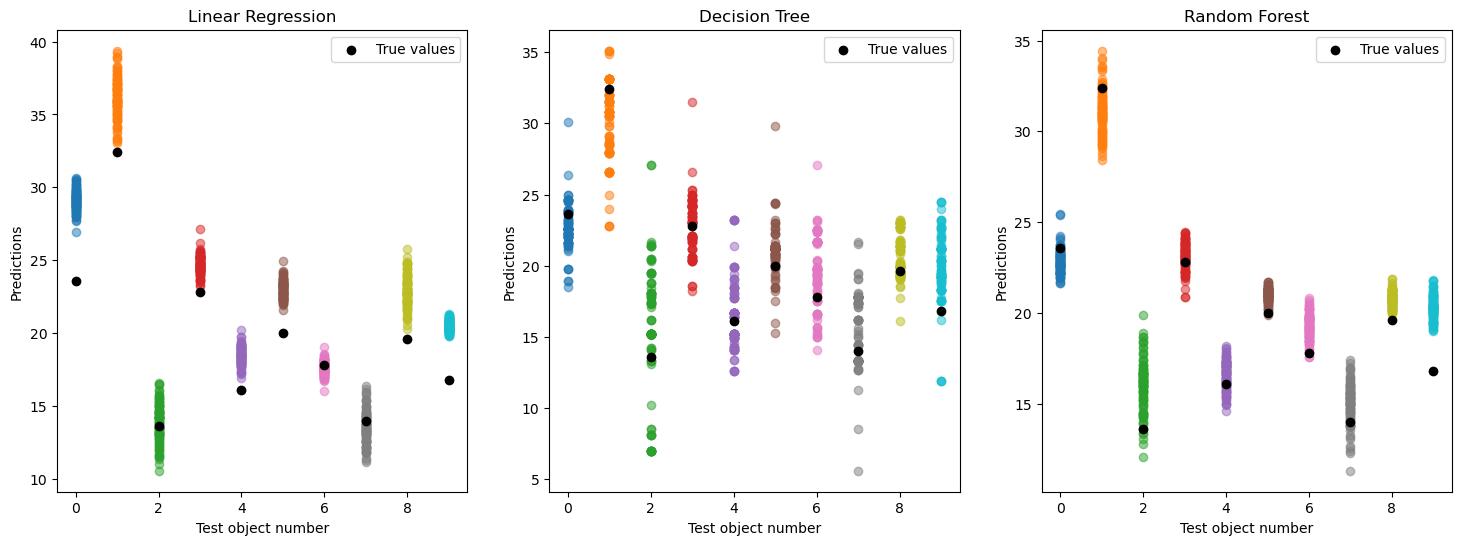

In [69]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plot_predictions(LinearRegression(), X, y, title="Linear Regression")

plt.subplot(1, 3, 2)
plot_predictions(DecisionTreeRegressor(), X, y, title="Decision Tree")

plt.subplot(1, 3, 3)
plot_predictions(RandomForestRegressor(), X, y, title="Random Forest")

plt.show()

__7. (0.5 баллов)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ Помним, что смещение характеризует отклонение средней модели от лучшей (в нашем случае - от верных ответов). Для наших графиков это отклонение средней по цветным точкам (условно, центр скопления) от черной точки. Можем видеть, что у линейной регрессии смещение большое - зачастую ни одна точка из проноза не попала в верное значение (не говоря уже о среднем). К дерева решений и Случайного леса разброс маленткий, так как среднее по цветным точкам находится около черных точек.

Разброс - в нашем случае на графике - это буквально вертикальный разброс цветных точек. Особенно хорошо это видно на дереве решений, где у ответов модели много выбросов и большое стандартное отклонение.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

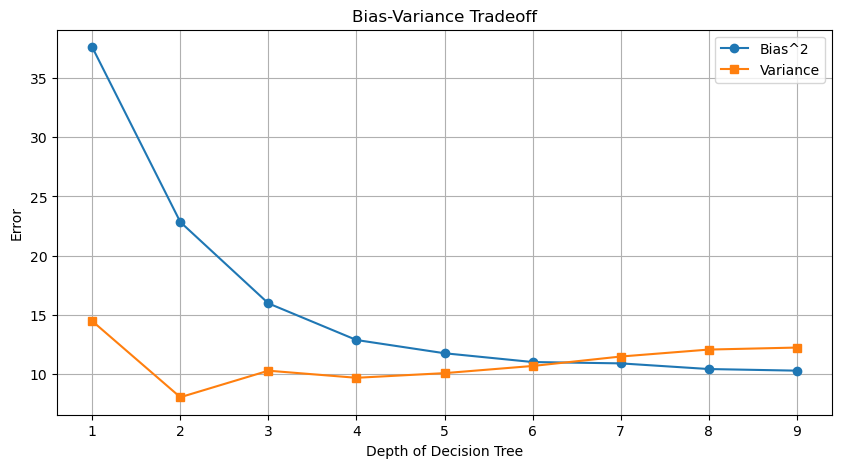

In [71]:
depths = list(range(1, 10))
biases = []
variences = []
for depth in range(1, 10):
    model = DecisionTreeRegressor(max_depth=depth)
    bias, varience, _ = compute_biase_variance(model, X, y)
    biases.append(bias)
    variences.append(varience)
plt.figure(figsize=(10, 5))
plt.plot(depths, biases, label='Bias^2', marker='o')
plt.plot(depths, variences, label='Variance', marker='s')
plt.title('Bias-Variance Tradeoff')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

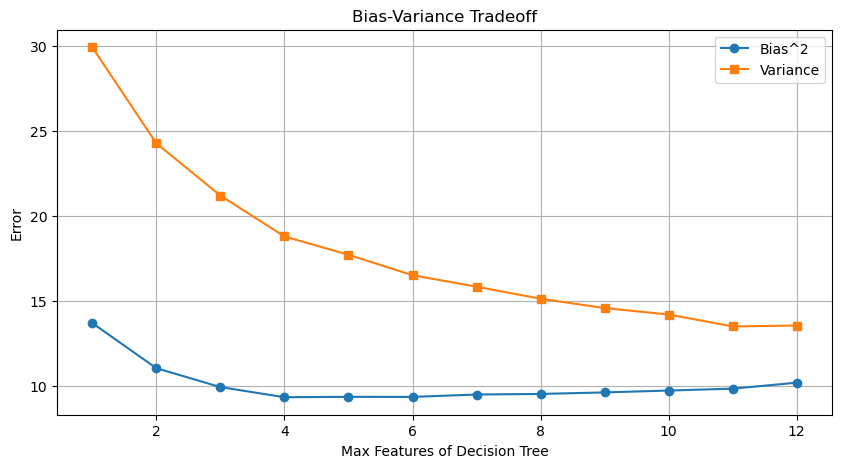

In [72]:
features = list(range(1, X.shape[1]))
biases = []
variences = []
for feature in features:
    model = DecisionTreeRegressor(max_features=feature)
    bias, varience, _ = compute_biase_variance(model, X, y)
    biases.append(bias)
    variences.append(varience)
plt.figure(figsize=(10, 5))
plt.plot(features, biases, label='Bias^2', marker='o')
plt.plot(features, variences, label='Variance', marker='s')
plt.title('Bias-Variance Tradeoff')
plt.xlabel('Max Features of Decision Tree')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

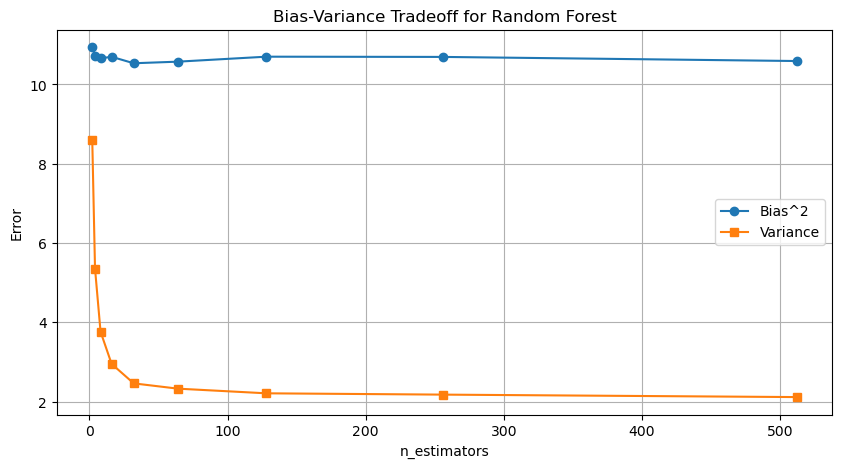

In [73]:
### your code here
n_estimators_range = 2 ** np.arange(1, 10)
biases = []
variences = []
for n_estimator in n_estimators_range:
    model = RandomForestRegressor(n_estimators=n_estimator, random_state=42)
    bias, varience, _ = compute_biase_variance(model, X, y)
    biases.append(bias)
    variences.append(varience)
plt.figure(figsize=(10, 5))
plt.plot(n_estimators_range, biases, label='Bias^2', marker='o')
plt.plot(n_estimators_range, variences, label='Variance', marker='s')
plt.title('Bias-Variance Tradeoff for Random Forest')
plt.xlabel('n_estimators')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

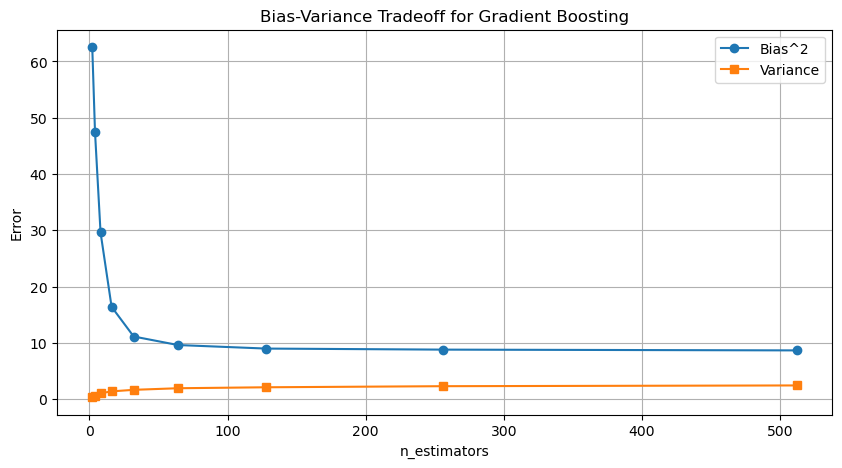

In [76]:
n_estimators_range = 2 ** np.arange(1, 10)
biases = []
variences = []
for n_estimator in n_estimators_range:
    model = GradientBoostingRegressor(n_estimators=n_estimator, random_state=42)
    bias, varience, _ = compute_biase_variance(model, X, y)
    biases.append(bias)
    variences.append(varience)
plt.figure(figsize=(10, 5))
plt.plot(n_estimators_range, biases, label='Bias^2', marker='o')
plt.plot(n_estimators_range, variences, label='Variance', marker='s')
plt.title('Bias-Variance Tradeoff for Gradient Boosting')
plt.xlabel('n_estimators')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

__10. (1.5 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__
### График №1 ### 
На дереве решений при увеличении максимальной глубины дерева (```max_depth```) смещение растет, так как дерево лучше подстраивается под данные, используя все большую имеющуюся информацию, при этом также с увеличением глубины разброс постепенно растет, что связанно с тем, что параллельно уменьшению смещения происходит переобучение модели под конкретные данные, из-за чего модели становятся разными. При этом в какой-то момент разброс становится больше смещения.
### График №2 ###
На втором графике можно заметить, что при увеличении ```max_features``` смещение уменьшается по той же причине, что и в прошлом пункте - модель может вобрать в себя большее количество информации, поэтому лучше адаптируется к данным и смещение улучшается. Разброс так же падает, и связано это с тем, что при маленьких значениях доступных признаков (которые в sklearn выбираются рандомно), деревья слишком отличаются друг от друга, однако по мере увеличения домтупных признаков, деревья становятся больше похожи друг на друга и разброc, логично, уменьшается.
### График №3 ###
При увеличении ```n_estimators``` на модели ```Random_Forest``` смещение практически никак не меняется, так как бэггинг никак не меняет смещение базовой модели (что доказывалось теоретически). Разброс в то же время сильно падал по той причине, что в теории при нуловой ковариации моделей, бэггинг должен уменьшать разброс в N раз. Однако в реале ковариация редко достигает 0. На графике мы видим, что при увеличении количества базовых моделей с 1 до 2, смещение сокразается с +- 9 до +- 4,5, что говорит о том, что ковариация у этих моделей низкая, однако затем с увеличением количества базовых моделей, разброс падает меньше, так как зависимость между ними растет. Таким образом, разброс падает, но чем больше моделей, тем меньше уменьшение.
### График №4 ###
Для модели градиентного бустинга при увеличении ```n_estimators``` смещение сильно падает, особенно на начальных шагах, так как GBM минимизирует ошибку, обучаясь на остаточных ошибках. Таким образом, GBM по сути осуществляет псевдо-градиентный спуск, в котором количество моделей эквивалентно количеству шагов в градиентном спуске, поэтому чем больше моделей, тем лучше предсказания и тем ниже смещение. Исходя из той же логики о том, что GMM строит последовательные предсказания, корректируя ошибки на каждом шаге, модели GBM обучаются примерно одинаково и разброc у них крайне маленький, оставаясь таким практически независимо от ```n_estimators```.



__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__